In [832]:
from my_data_reader import get_data
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import networkx as nx
import numpy as np
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [833]:
data=get_data('Amazon')
print(data.keys())
print([(i,type(v)) for i,v in data.items()])

Adj = np.zeros(data['adj_norm'][2])
i=0
for cord in data['adj_norm'][0]:
    Adj[cord[0]][cord[1]]=data['adj_norm'][1][i]
    i+=1
Adj=torch.Tensor(Adj)
# Adj.require_grad=False

dict_keys(['adj', 'num_features', 'num_nodes', 'features_nonzero', 'adj_norm', 'adj_label', 'features', 'labels'])
[('adj', <class 'scipy.sparse.lil.lil_matrix'>), ('num_features', <class 'int'>), ('num_nodes', <class 'int'>), ('features_nonzero', <class 'int'>), ('adj_norm', <class 'tuple'>), ('adj_label', <class 'tuple'>), ('features', <class 'tuple'>), ('labels', <class 'numpy.ndarray'>)]


In [834]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [835]:
class GCNConv(nn.Module):
    def __init__(self, A, in_channels, out_channels):
        super(GCNConv, self).__init__()
        self.A_hat = A
        self.W     = nn.Parameter(torch.rand(in_channels,out_channels))
    
    def forward(self, X):
        out = torch.mm(torch.mm(self.A_hat, X), self.W)
        return out

class NLGCN(nn.Module):
    def __init__(self, channels):
        super(NLGCN, self).__init__()
        self.channels=channels
        self.c=nn.Parameter(torch.rand(channels,1))
        self.conv1D=nn.Conv1d(1,1,3,padding=1)
        
    def forward(self, X):
        Av=X.matmul(self.c)
        indices_sorted=Av.argsort()
        indices_reorder=torch.sort(indices_sorted).values
        X=X[indices_sorted]
        shape=np.shape(X)
        X=torch.reshape(X, (shape[0],shape[2]))
        X=torch.transpose(X,0,1)
        X=torch.reshape(X,(shape[2],shape[1],shape[0]))
        X=self.conv1D(X)
        X=torch.reshape(X,(shape[2],shape[0]))
        X=torch.transpose(X,1,0)
        X=X[indices_reorder]
        X=torch.reshape(X,(shape[0],shape[2]))
        return X

In [836]:
class Net(torch.nn.Module):
    def __init__(self,A, nfeat, nhid1,nhid2,nhid3, nout):
        super(Net, self).__init__()
        self.conv1 = GCNConv(A,nfeat, nhid1)
        self.conv2 = GCNConv(A,nhid1, nhid2)
        self.nlgcn=NLGCN(nhid2)
        self.dense1=nn.Linear(nhid2,nhid2)
        self.dense2=nn.Linear(nhid2,nhid2)
        self.conv3 = GCNConv(A,nhid2, nhid3)
        self.conv4 = GCNConv(A,nhid3, nout)
        self.dec2 = GCNConv(A,nhid2,nhid3)
        
    def forward(self,X):
        H  = self.conv1(X)
        H = torch.relu(H)
        H  = self.conv2(H)
        H = torch.relu(H)
        H=self.nlgcn(H)
        
        H = self.dense1(H)
        H = torch.relu(H)
        H = self.dense2(H)
        H = torch.relu(H)
        
        #A=self.dec2(H)
        A=torch.matmul(H,H.T)
        A=torch.sigmoid(A)
        
        Att  = self.conv3(H)
        Att = torch.relu(Att)
        Att = self.conv4(Att)
        Att = torch.softmax(Att,1)
        return Att,A
    
T = Net(Adj,21,12,10,12,21)
#T = Net(Adj,28,15,10,15,28)
#T = Net(Adj,10,7,5,7,10)
print(T)

Net(
  (conv1): GCNConv()
  (conv2): GCNConv()
  (nlgcn): NLGCN(
    (conv1D): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (dense1): Linear(in_features=10, out_features=10, bias=True)
  (dense2): Linear(in_features=10, out_features=10, bias=True)
  (conv3): GCNConv()
  (conv4): GCNConv()
  (dec2): GCNConv()
)


In [837]:
X=np.zeros(shape=data['features'][2],dtype='float32')
i=0
for cord in data['features'][0]:
#     X[cord[0]][cord[1]]=data['features'][1][i]
    X[cord[0]][cord[1]]=1
    i+=1
print('feature matrix')
X=torch.tensor(X)
# X.require_grad=False
X

feature matrix


tensor([[1., 1., 1.,  ..., 1., 0., 0.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 0.],
        ...,
        [0., 0., 1.,  ..., 1., 1., 0.],
        [0., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.]])

In [838]:
Adj=data['adj'].toarray()
Adj.astype('float32')
Adj=torch.Tensor(Adj)
# Adj.require_grad=False
print("Adjacency Matrix")
Adj

Adjacency Matrix


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [839]:
#criterion = torch.nn.L1Loss()
optimizer = optim.Adam(T.parameters(), lr=0.05)

#loss=criterion(T(X)[0],X)

In [840]:
for i in range(101):
    optimizer.zero_grad()
    #loss=criterion(T(X), X)
    feat_loss=torch.sqrt(torch.sum(torch.square(T(X)[0]-X)))
    struct_loss=torch.sqrt(torch.sum(torch.square(T(X)[1]-Adj)))
    loss=torch.div(torch.add(feat_loss,struct_loss),2)
    loss.backward()
    optimizer.step()
    l=(T(X));

    if i%20==0:
        print("Epoch : ",i," Loss: =", loss.item())

Epoch :  0  Loss: = 779.7252197265625
Epoch :  20  Loss: = 425.5654296875
Epoch :  40  Loss: = 425.5654296875
Epoch :  60  Loss: = 425.5654296875
Epoch :  80  Loss: = 425.5654296875
Epoch :  100  Loss: = 425.5654296875


AUC score :  0.7337101747173689


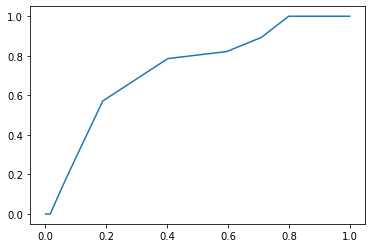

In [841]:
with torch.no_grad():
    feat_loss=torch.square(T(X)[0]-X)
    fl=[]
    for i in feat_loss:
        fl.append(np.sqrt(torch.sqrt(torch.sum(i))))
    struct_loss=torch.square(T(X)[1]-Adj)
    sl=[]
    for i in struct_loss:
        sl.append(np.sqrt(torch.sqrt(torch.sum(i))))
    diff=[]
    for i in range(len(feat_loss)):
        diff.append((fl[i]+sl[i])/2)
fpr, tpr, thresholds = metrics.roc_curve(data['labels'], diff, pos_label=None)
print("AUC score : ",roc_auc_score(data['labels'], diff))
# print(fpr,tpr)
plt.plot(fpr,tpr)
plt.show()

In [842]:
Out=T(X)[1].detach().numpy()

In [843]:
A=Adj.detach().numpy()

In [844]:
edge_anomalies=[]
for i in range(len(A)):
    for j in range(len(A)):
        if Out[i][j]==0 and A[i][j]==1:
            edge_anomalies.append((i,j))
len(edge_anomalies)

0

In [ ]:
count=0
for i in range(len(A)):
    for j in range(len(A)):
         if Out[i][j]==0.5:
                count+=1
print(count)

In [ ]:
np.shape(Out)

In [ ]:
Out

In [ ]:
T(X)[0].size()